In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+115.g1aecabf anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

	Single-cell RNAseq data was collected on whole early mouse embryos. Each experiment consists of 4-10 replicates of developmental stages 6.5, 7.0, 7.5, 8.0, 8.5 for wild-type sequenced with 10X Genomics single-cell RNA sequencing system.

In [4]:
# Set up data loading

#Data files
sample_strings = ['E7.5_2', 'E8.0_1ab', 'E8.5_1ab']
file_base = '../data/mammalian-embryogenesis/GSE122187_WT_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
#cc_genes_file = '../Macosko_cell_cycle_genes.txt'

In [5]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
data_file = file_base+sample+data_file_end
barcode_file = file_base+sample+barcode_file_end
gene_file = file_base+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['stage'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['exp_number'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
print(adata)

... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.5_2_matrix.h5ad
AnnData object with n_obs × n_vars = 13610 × 27998 
    obs: 'sample', 'stage', 'exp_number'
    var: 'gene_id'


In [6]:
print(adata.obs['sample'])

barcode
AAACCTGAGCCCAATT-1    E7.5_2
AAACCTGAGGAATTAC-1    E7.5_2
AAACCTGAGGTGCAAC-1    E7.5_2
AAACCTGAGTGCGATG-1    E7.5_2
AAACCTGAGTTACCCA-1    E7.5_2
AAACCTGAGTTAGGTA-1    E7.5_2
AAACCTGCAGAGCCAA-1    E7.5_2
AAACCTGCAGATGGGT-1    E7.5_2
AAACCTGCAGATTGCT-1    E7.5_2
AAACCTGCAGCTGTAT-1    E7.5_2
AAACCTGCAGTAGAGC-1    E7.5_2
AAACCTGCATAGACTC-1    E7.5_2
AAACCTGCATTGGTAC-1    E7.5_2
AAACCTGGTAGTGAAT-1    E7.5_2
AAACCTGGTATAGTAG-1    E7.5_2
AAACCTGGTCGACTAT-1    E7.5_2
AAACCTGGTCGCATAT-1    E7.5_2
AAACCTGGTCGTCTTC-1    E7.5_2
AAACCTGGTGACCAAG-1    E7.5_2
AAACCTGTCACATACG-1    E7.5_2
AAACCTGTCCAATGGT-1    E7.5_2
AAACCTGTCCCGGATG-1    E7.5_2
AAACCTGTCCTCATTA-1    E7.5_2
AAACCTGTCGTCTGAA-1    E7.5_2
AAACCTGTCTACCTGC-1    E7.5_2
AAACGGGAGAATCTCC-1    E7.5_2
AAACGGGAGACAATAC-1    E7.5_2
AAACGGGAGACCTTTG-1    E7.5_2
AAACGGGAGCCACGTC-1    E7.5_2
AAACGGGAGCTAGGCA-1    E7.5_2
                       ...  
TTTGGTTTCAGATAAG-1    E7.5_2
TTTGGTTTCGAACTGT-1    E7.5_2
TTTGGTTTCTACTATC-1    E7.5_2
TTTGGT

# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    data_file = file_base+sample+data_file_end 
    barcode_file = file_base+sample+barcode_file_end
    gene_file = file_base+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['stage'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['exp_number'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample')
    #adata.obs.drop(columns=['sample'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

    
print(adata)


Once the data is read in and annotated, we test whether we have the expected number of cells for each region, mouse (donor), and sample.

In [7]:
# Annotate the data sets
print(adata.obs)
print(adata.obs['stage'].value_counts())
print('')
print(adata.obs['exp_number'].value_counts())
print('')
#print(adata.obs['sample'].value_counts())

                    sample stage exp_number
barcode                                    
AAACCTGAGCCCAATT-1  E7.5_2  E7.5          2
AAACCTGAGGAATTAC-1  E7.5_2  E7.5          2
AAACCTGAGGTGCAAC-1  E7.5_2  E7.5          2
AAACCTGAGTGCGATG-1  E7.5_2  E7.5          2
AAACCTGAGTTACCCA-1  E7.5_2  E7.5          2
AAACCTGAGTTAGGTA-1  E7.5_2  E7.5          2
AAACCTGCAGAGCCAA-1  E7.5_2  E7.5          2
AAACCTGCAGATGGGT-1  E7.5_2  E7.5          2
AAACCTGCAGATTGCT-1  E7.5_2  E7.5          2
AAACCTGCAGCTGTAT-1  E7.5_2  E7.5          2
AAACCTGCAGTAGAGC-1  E7.5_2  E7.5          2
AAACCTGCATAGACTC-1  E7.5_2  E7.5          2
AAACCTGCATTGGTAC-1  E7.5_2  E7.5          2
AAACCTGGTAGTGAAT-1  E7.5_2  E7.5          2
AAACCTGGTATAGTAG-1  E7.5_2  E7.5          2
AAACCTGGTCGACTAT-1  E7.5_2  E7.5          2
AAACCTGGTCGCATAT-1  E7.5_2  E7.5          2
AAACCTGGTCGTCTTC-1  E7.5_2  E7.5          2
AAACCTGGTGACCAAG-1  E7.5_2  E7.5          2
AAACCTGTCACATACG-1  E7.5_2  E7.5          2
AAACCTGTCCAATGGT-1  E7.5_2  E7.5

In [8]:
# Checking the total size of the data set
adata.shape

(13610, 27998)

In [9]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'exp_number' as categorical


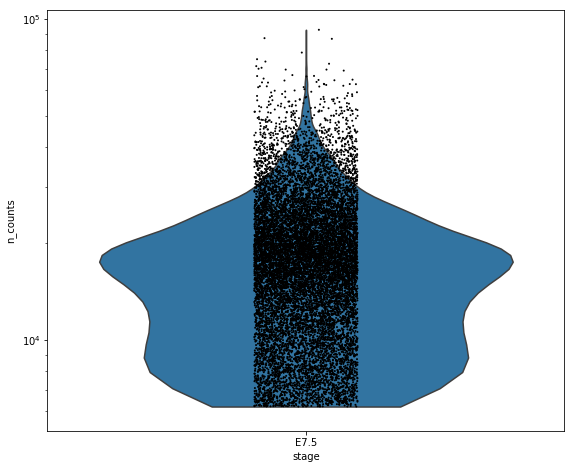

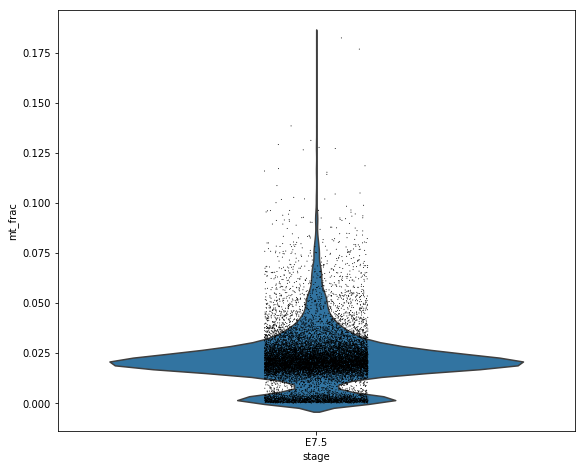

In [10]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='stage', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='stage')

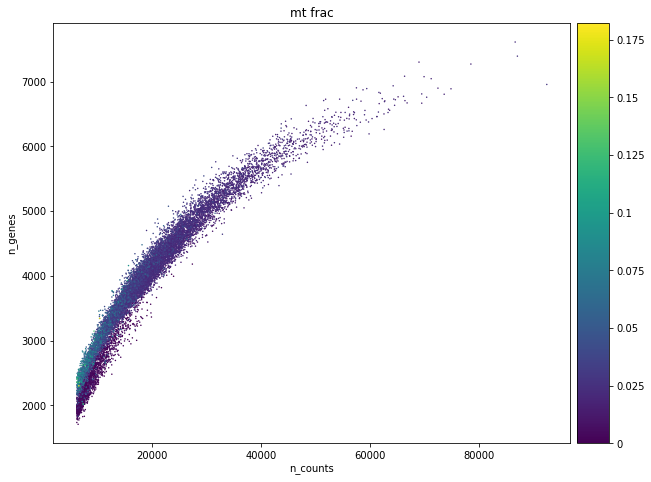

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


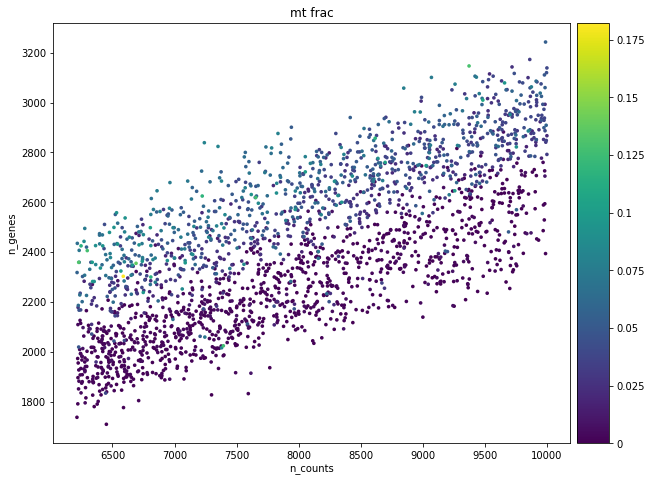

In [11]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

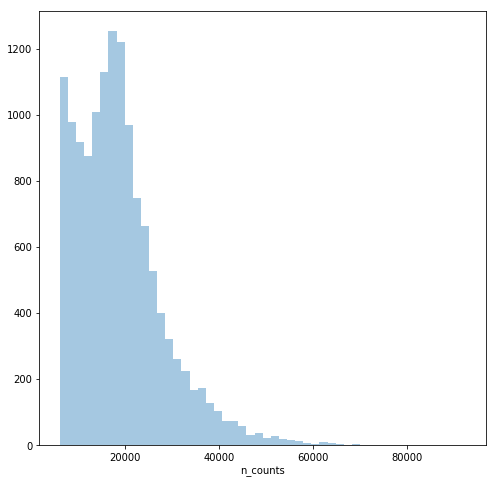

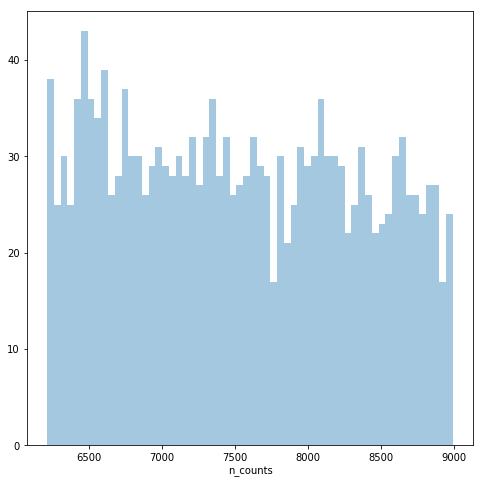

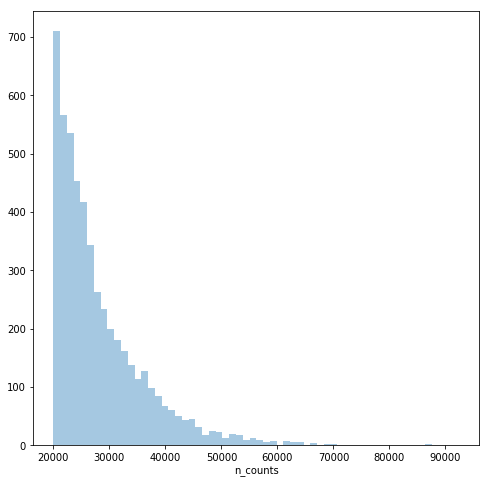

In [12]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<9000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>20000], kde=False, bins=60)
plt.show()